This notebook will allow anyone to reproduce figures including the triangle plot, redshift vs. rates, metallicity, delay time distribution, and the final master plot that displays the variations. 

In order to process the rate info:
- Run fast cosmic integration
- read in the data
- use the masses, mixture weights, and rates to plot the triangle plot

### 1) Reading in the data

In [1]:
#imports!

# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os
from scipy import stats
import seaborn as sns
import matplotlib as mpl

# Add the subdir to sys.path
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')

# Now you can import the module
import useful_fncs 

# import for axes labels 
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [21]:
# Set the appropriate path to the data file + read in the data

pathToH5 = '/home/jovyan/CompasOutput/v03.21.00/N5e6_MassiveWDWD_NSNS_AM_circumbinary/MainRun/COMPAS_Output_wWeights.h5'
Data  = h5.File(pathToH5)

In [22]:
# we want to use information in the double compact object group
DCOs = Data['BSE_Double_Compact_Objects']

# first we want to investigate how many of each type of DCO there is
stellar_types_1 = DCOs['Stellar_Type(1)'][()]
stellar_types_2 = DCOs['Stellar_Type(2)'][()]


# we need the masses, mixture weight, and rate info
mass1 = DCOs['Mass(1)'][()]
mass2 = DCOs['Mass(2)'][()]
rates_z0_DCO = Data['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]

In [17]:
# let's add everything to a dataframe so we can analyze things easier

data = {
  "Stellar_Type(1)": stellar_types_1,
  "Stellar_Type(2)": stellar_types_2,
  "Mass(1)": mass1,
  "Mass(2)": mass2
}

DCOs = pd.DataFrame(data)
DCOs

,Stellar_Type(1),Stellar_Type(2),Mass(1),Mass(2)
0,11,11,0.851714,0.568181
1,11,11,1.071336,0.865158
2,11,11,0.659060,0.654633
3,14,14,14.797602,9.624248
4,11,10,0.598184,0.210156
...,...,...,...,...
3766060,10,11,0.521925,0.625393
3766061,11,10,0.571643,0.229576
3766062,11,11,0.834146,0.724055
3766063,11,10,0.600973,0.287064


### 2) Analyze the Data

In [18]:
# let's first count how many NSNS, NSWD, and WDWD systems there are

NSNS_systems_bool = np.logical_and(DCOs['Stellar_Type(1)']==14, DCOs['Stellar_Type(2)']==14)
print("There are {} NSNS systems." .format(sum(NSNS_systems_bool)))

HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(DCOs)
carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))
print("There are {} COWD systems." .format(sum(carbon_oxygen_bool)))

WDWD_bool = np.logical_and(np.isin(stellar_type_1,[10,11,12]),np.isin(stellar_type_2,[10,11,12]))
print("There are {} WDWD systems." .format(sum(WDWD_bool)))

There are 1981 NSNS systems.
There are 3698406 COWD systems.
There are 3264941 WDWD systems.


### 3) Let's now make the triangle plot!

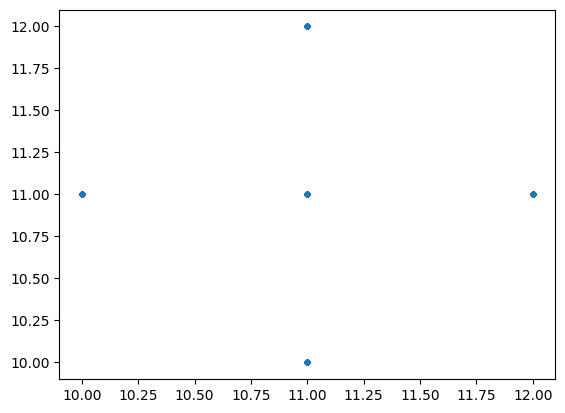

In [7]:
# let's make sure we are only selecting WDWDs
stellar_type_1 = np.array(DCOs['Stellar_Type(1)'])
stellar_type_2 = np.array(DCOs['Stellar_Type(2)'])
plt.plot(stellar_type_1[carbon_oxygen_bool], stellar_type_2[carbon_oxygen_bool],'.')

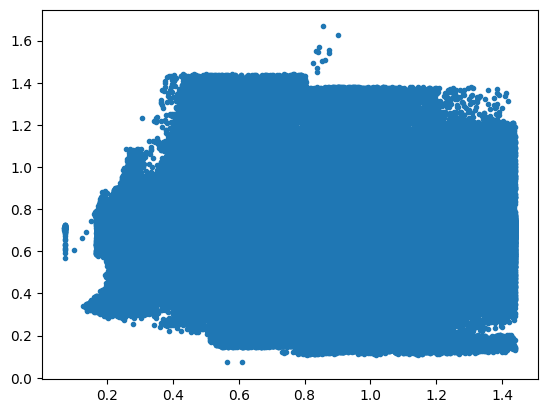

In [8]:
Mass1 = np.array(DCOs['Mass(1)'])
Mass2 = np.array(DCOs['Mass(2)'])
plt.plot(Mass1[carbon_oxygen_bool], Mass2[carbon_oxygen_bool], '.')

In [19]:
len(rates_z0_DCO)

2846485

In [9]:
WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]

IndexError: boolean index did not match indexed array along axis 0; size of axis is 2807120 but size of corresponding boolean axis is 3310138

111520.48223758064 111520.48223758064


Text(0, 0.5, '$M_{2}$[$M_{\\odot}$]')

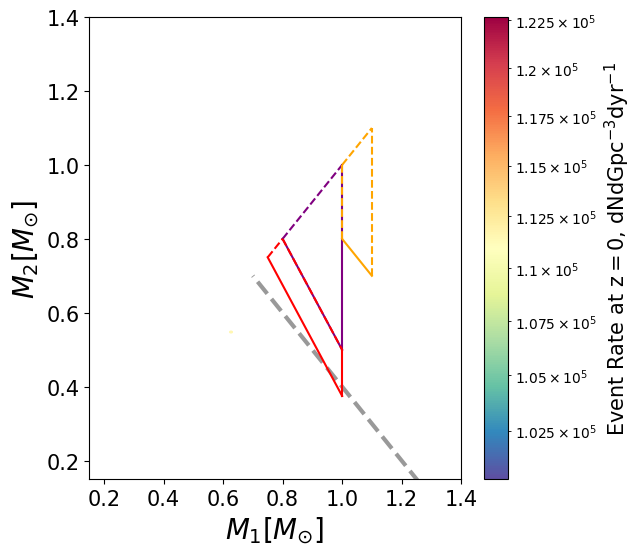

In [ ]:
# change figuresize
fig, ax = plt.subplots(figsize = (6,6))

# let's define a few things first
WDWD_merger_rate_Z0 = rates_info[WDWD_systems_bool]
vmin = 10**-1
vmax = 10**3


# for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
hb = plt.hexbin(DCOs['Mass(1)'][WDWD_systems_bool],DCOs['Mass(1)'][WDWD_systems_bool],C=WDWD_merger_rate_Z0, gridsize=(15,15), reduce_C_function = np.sum, 
                cmap=sns.color_palette("Spectral_r",as_cmap=True),norm='log',vmin=vmin,vmax=vmax) # C is value of weights, 1e3- 10**3
                # use symlog when you also want to cover negative values    
# right now we are not dividing by the bin size, so when we chage the bins - it changes the shape of our dist 
zvalue_array = hb.get_array() # the merger rates of the histigram
print(min(zvalue_array),max(zvalue_array)) # helps us detemine what vim and vmax should be and what the bin size should be 

# colorbar
cb = plt.colorbar()
cb.set_label(label="Event Rate at $\mathrm{z =0}$, $\mathrm{dNdGpc^{-3}dyr^{-1}}$", fontsize = 15)

max_mass_lim = 1.4
plt.ylim(0.15,max_mass_lim)
plt.xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(mass1[WDWD_systems[0]])
ylim = max(mass1[WDWD_systems[0]])

linecolors = 'white'
linewidths = 4

plt.axline((0,0), (max(mass1[WDWD_systems[0]]),max(mass1[WDWD_systems[0]])), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
plt.plot([0.8,1],[0.8,0.5],color='purple') # bottom boundary
plt.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
plt.plot([0.8,1.0],[0.8,1.0],color='purple',ls='--') # top boundary 

# # chandrasekar mass line
plt.plot((1.4,0.7),(0,0.7),color='black', lw=3, ls='--', alpha = 0.4)


# red region - hypervelocity WDs
plt.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
plt.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
plt.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
plt.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
plt.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
plt.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
plt.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
plt.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary



plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("$M_{1}$[$M_{\odot}$]",fontsize=20)
plt.ylabel("$M_{2}$[$M_{\odot}$]",fontsize=20)

# increase tick label sizes

## save figure:
# plt.savefig("./figures/triangle_plots/triangle_CEalpha1.png",bbox_inches='tight',pad_inches=0.1)

### 4) Let's close the file!

In [20]:
Data.close()